# PMEncoder vs IMEncoder 可視化

PMEncoder（位相変調）とIMEncoder（強度変調）の出力特性を2次元入力空間で比較します。

In [256]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams, font_manager
_available_fonts = {f.name for f in font_manager.fontManager.ttflist}
rcParams['font.family'] = 'Times New Roman' if 'Times New Roman' in _available_fonts else 'DejaVu Serif'
import torch
import sys
import os

# パスを追加
sys.path.append(os.path.abspath("../.."))
from models.IntegrationModel import PMEncoder, IMEncoder

# デバイス設定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [257]:
# パラメータ設定
alpha = np.pi
input_dim = 2  # 2次元入力
output_dim = 1  # 1次元出力（可視化のため）
resolution = 300  # グリッド解像度

# エンコーダーの初期化
pm_encoder = PMEncoder(input_dim=input_dim, output_dim=output_dim, alpha=alpha, device=device, seed=42)
im_encoder = IMEncoder(input_dim=input_dim, output_dim=output_dim, alpha=alpha, device=device)

print(f"PMEncoder - alpha: {pm_encoder.alpha}")
print(f"PMEncoder - B shape: {pm_encoder.B.shape}")
print(f"IMEncoder - B shape: {im_encoder.B.shape}")

PMEncoder - alpha: tensor([2.4019, 2.6075], device='cuda:0')
PMEncoder - B shape: torch.Size([1, 2])
IMEncoder - B shape: torch.Size([1, 2])


In [258]:
# 2次元入力空間の作成
x1 = np.linspace(0, 1, resolution)  # PMEncoderは[0,1]を想定
x2 = np.linspace(0, 1, resolution)
X1, X2 = np.meshgrid(x1, x2)

# 入力データをテンソルに変換
input_grid = np.stack([X1.flatten(), X2.flatten()], axis=1)  # (resolution^2, 2)
input_tensor = torch.tensor(input_grid, dtype=torch.float32).to(device)

print(f"Input tensor shape: {input_tensor.shape}")
print(f"Input range: [{input_tensor.min():.3f}, {input_tensor.max():.3f}]")

Input tensor shape: torch.Size([90000, 2])
Input range: [0.000, 1.000]


In [259]:
# エンコーダーの出力を計算
with torch.no_grad():
    # PMEncoder（位相変調）
    pm_output = pm_encoder(input_tensor)
    I_PM = pm_output.cpu().numpy().reshape(resolution, resolution)
    
    # IMEncoder（強度変調）
    im_output = im_encoder(input_tensor)
    I_IM = im_output.cpu().numpy().reshape(resolution, resolution)

print(f"PM output range: [{I_PM.min():.3f}, {I_PM.max():.3f}]")
print(f"IM output range: [{I_IM.min():.3f}, {I_IM.max():.3f}]")

PM output range: [0.208, 0.793]
IM output range: [0.000, 0.226]


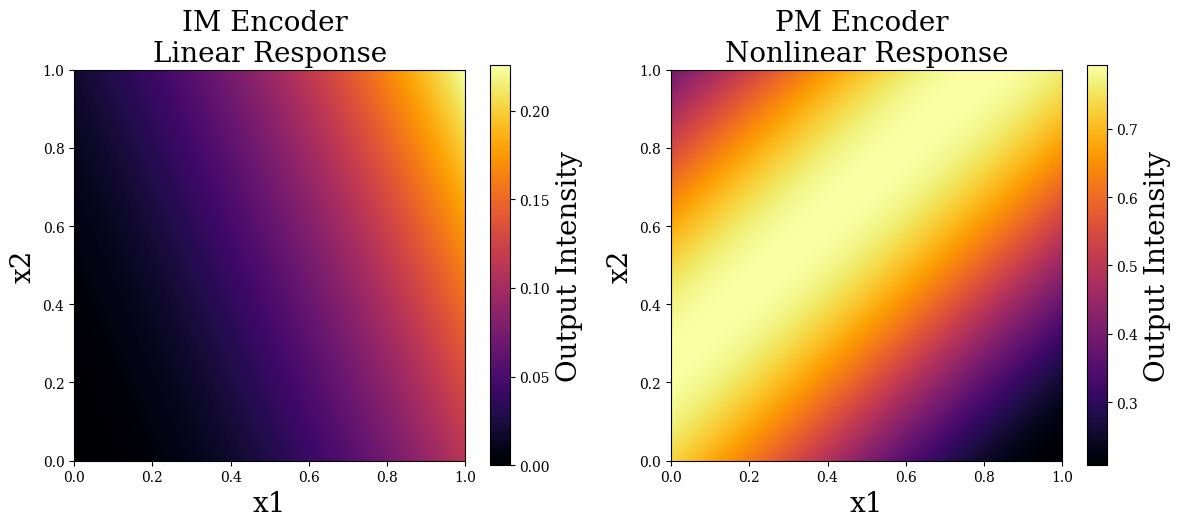

In [260]:
# 可視化
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# IMEncoder（線形的）
im1 = ax[0].imshow(I_IM, extent=[0, 1, 0, 1], origin='lower', cmap='inferno')
ax[0].set_title('IM Encoder \nLinear Response', fontsize=20)
ax[0].set_xlabel('x1', fontsize=20)
ax[0].set_ylabel('x2', fontsize=20)
cbar1 = plt.colorbar(im1, ax=ax[0], label='Output Intensity')
cbar1.set_label('Output Intensity', fontsize=20)
cbar1.ax.tick_params(labelsize=10)

# PMEncoder（非線形）
im2 = ax[1].imshow(I_PM, extent=[0, 1, 0, 1], origin='lower', cmap='inferno')
ax[1].set_title('PM Encoder \nNonlinear Response', fontsize=20)
ax[1].set_xlabel('x1', fontsize=20)
ax[1].set_ylabel('x2', fontsize=20)
cbar2 = plt.colorbar(im2, ax=ax[1], label='Output Intensity')
cbar2.set_label('Output Intensity', fontsize=20)
cbar2.ax.tick_params(labelsize=10)

plt.tight_layout()
plt.show()

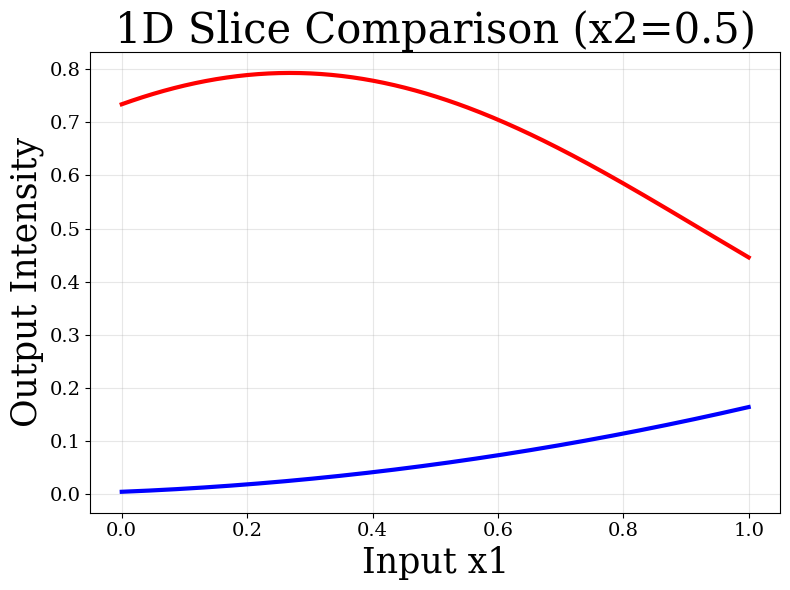

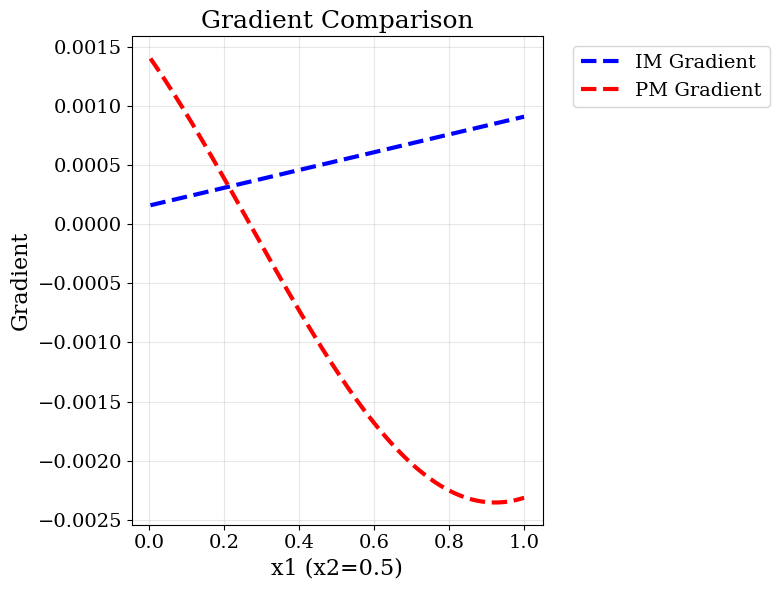

In [261]:
# 1次元スライスでの詳細比較
# x2=0.5での断面を取得
slice_idx = resolution // 2
x1_slice = x1
im_slice = I_IM[slice_idx, :]
pm_slice = I_PM[slice_idx, :]

# グラフ1: 出力強度の比較
plt.figure(figsize=(8, 6))
plt.plot(x1_slice, im_slice, 'b-', linewidth=3, label='IM Encoder')
plt.plot(x1_slice, pm_slice, 'r-', linewidth=3, label='PM Encoder')
plt.xlabel('Input x1', fontsize=25)
plt.ylabel('Output Intensity', fontsize=25)
plt.title('1D Slice Comparison (x2=0.5)', fontsize=30)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

# グラフ2: 勾配の比較
im_grad = np.gradient(im_slice)
pm_grad = np.gradient(pm_slice)

plt.figure(figsize=(8, 6))
plt.plot(x1_slice[1:], im_grad[1:], 'b--', linewidth=3, label='IM Gradient')
plt.plot(x1_slice[1:], pm_grad[1:], 'r--', linewidth=3, label='PM Gradient')
plt.xlabel('x1 (x2=0.5)', fontsize=16)
plt.ylabel('Gradient', fontsize=16)
plt.title('Gradient Comparison', fontsize=18)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

In [262]:
# 統計情報の比較
print("=== エンコーダー出力の統計情報 ===")
print(f"IM Encoder:")
print(f"  平均: {I_IM.mean():.4f}")
print(f"  標準偏差: {I_IM.std():.4f}")
print(f"  最小値: {I_IM.min():.4f}")
print(f"  最大値: {I_IM.max():.4f}")
print(f"  ダイナミックレンジ: {I_IM.max() - I_IM.min():.4f}")

print(f"\nPM Encoder:")
print(f"  平均: {I_PM.mean():.4f}")
print(f"  標準偏差: {I_PM.std():.4f}")
print(f"  最小値: {I_PM.min():.4f}")
print(f"  最大値: {I_PM.max():.4f}")
print(f"  ダイナミックレンジ: {I_PM.max() - I_PM.min():.4f}")

# 線形性の測定（相関係数）
x_sum = X1 + X2  # 入力の線形結合
im_corr = np.corrcoef(x_sum.flatten(), I_IM.flatten())[0, 1]
pm_corr = np.corrcoef(x_sum.flatten(), I_PM.flatten())[0, 1]

print(f"\n=== 線形性の測定（入力和との相関） ===")
print(f"IM Encoder 相関係数: {im_corr:.4f}")
print(f"PM Encoder 相関係数: {pm_corr:.4f}")

=== エンコーダー出力の統計情報 ===
IM Encoder:
  平均: 0.0675
  標準偏差: 0.0513
  最小値: 0.0000
  最大値: 0.2257
  ダイナミックレンジ: 0.2257

PM Encoder:
  平均: 0.6420
  標準偏差: 0.1541
  最小値: 0.2079
  最大値: 0.7929
  ダイナミックレンジ: 0.5850

=== 線形性の測定（入力和との相関） ===
IM Encoder 相関係数: 0.9008
PM Encoder 相関係数: 0.0345


In [263]:
# 高次元出力での比較（output_dim=4）
print("=== 高次元出力での比較 ===")
output_dim_multi = 4

pm_encoder_multi = PMEncoder(input_dim=2, output_dim=output_dim_multi, alpha=alpha, device=device, seed=42)
im_encoder_multi = IMEncoder(input_dim=2, output_dim=output_dim_multi, alpha=alpha, device=device)

# サンプル入力での出力確認
sample_input = torch.tensor([[0.0, 0.0], [0.5, 0.5], [1.0, 1.0]], dtype=torch.float32).to(device)

with torch.no_grad():
    pm_multi_out = pm_encoder_multi(sample_input)
    im_multi_out = im_encoder_multi(sample_input)

print(f"サンプル入力: {sample_input.cpu().numpy()}")
print(f"PM Encoder 出力 (4次元):")
print(pm_multi_out.cpu().numpy())
print(f"IM Encoder 出力 (4次元):")
print(im_multi_out.cpu().numpy())

# 出力の多様性（各次元の分散）
pm_var = pm_multi_out.var(dim=0).cpu().numpy()
im_var = im_multi_out.var(dim=0).cpu().numpy()

print(f"\n各次元の分散:")
print(f"PM Encoder: {pm_var}")
print(f"IM Encoder: {im_var}")

=== 高次元出力での比較 ===
サンプル入力: [[0.  0. ]
 [0.5 0.5]
 [1.  1. ]]
PM Encoder 出力 (4次元):
[[0.73092014 0.26907986]
 [0.7482037  0.25179642]
 [0.7628645  0.23713557]]
IM Encoder 出力 (4次元):
[[0.         0.         0.         0.        ]
 [0.0564189  0.30132297 0.5532314  0.00478928]
 [0.2256756  1.2052919  2.2129257  0.01915714]]

各次元の分散:
PM Encoder: [0.00025568 0.00025568]
IM Encoder: [1.3793400e-02 3.9344731e-01 1.3262817e+00 9.9394747e-05]


# より適切な線形性/非線形性の評価

上記の1次元出力では情報が圧縮されすぎているため、以下でより詳細な分析を行います。

In [264]:
# 1. 高次元出力での包括的な線形性評価
print("=== 高次元出力での線形性評価 ===")
output_dim_large = 16  # より高次元での評価

pm_encoder_large = PMEncoder(input_dim=2, output_dim=output_dim_large, alpha=alpha, device=device, seed=42)
im_encoder_large = IMEncoder(input_dim=2, output_dim=output_dim_large, alpha=alpha, device=device)

# テスト入力のセット（線形性をチェック）
test_inputs = torch.tensor([
    [0.0, 0.0], [1.0, 0.0], [0.0, 1.0], [1.0, 1.0],  # 角の点
    [0.5, 0.5], [0.3, 0.7], [0.8, 0.2]  # 中間の点
], dtype=torch.float32).to(device)

with torch.no_grad():
    pm_large_out = pm_encoder_large(test_inputs)
    im_large_out = im_encoder_large(test_inputs)

# 線形性テスト: f(ax + by) ≈ af(x) + bf(y) が成り立つか？
x1, x2 = test_inputs[1:2], test_inputs[2:3]  # [1,0], [0,1]
a, b = 0.3, 0.7
linear_input = a * x1 + b * x2  # [0.3, 0.7]

with torch.no_grad():
    # 実際の出力
    pm_actual = pm_encoder_large(linear_input)
    im_actual = im_encoder_large(linear_input)
    
    # 線形予測
    pm_linear_pred = a * pm_encoder_large(x1) + b * pm_encoder_large(x2)
    im_linear_pred = a * im_encoder_large(x1) + b * im_encoder_large(x2)

# 線形性の誤差を計算
pm_linearity_error = torch.norm(pm_actual - pm_linear_pred).item()
im_linearity_error = torch.norm(im_actual - im_linear_pred).item()

print(f"線形性テスト結果:")
print(f"PM Encoder 線形性誤差: {pm_linearity_error:.6f}")
print(f"IM Encoder 線形性誤差: {im_linearity_error:.6f}")
print(f"相対的非線形性 (PM/IM): {pm_linearity_error/im_linearity_error:.2f}x")

=== 高次元出力での線形性評価 ===
線形性テスト結果:
PM Encoder 線形性誤差: 0.604328
IM Encoder 線形性誤差: 1.297747
相対的非線形性 (PM/IM): 0.47x



=== ヤコビアン分析（勾配の均一性） ===
ヤコビアンノルムの統計:
PM Encoder - 平均: 0.0000, 標準偏差: 0.0000
IM Encoder - 平均: 9.4111, 標準偏差: 4.3539
勾配の変動性比 (PM/IM): 0.00x


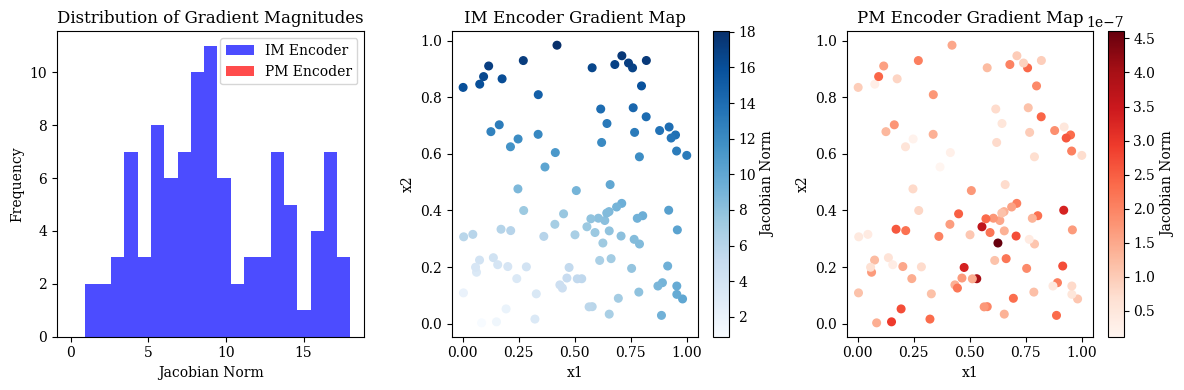

In [265]:
# 2. ヤコビアン（勾配）の比較
print("\n=== ヤコビアン分析（勾配の均一性） ===")

# 入力空間でのサンプリング
n_samples = 100
input_samples = torch.rand(n_samples, 2).to(device)
input_samples.requires_grad_(True)

# ヤコビアンの計算関数
def compute_jacobian_norm(encoder, inputs):
    jacobian_norms = []
    for i in range(inputs.shape[0]):
        x = inputs[i:i+1]
        x.requires_grad_(True)
        output = encoder(x).sum()  # スカラー化
        grad = torch.autograd.grad(output, x, create_graph=True)[0]
        jacobian_norms.append(grad.norm().item())
    return np.array(jacobian_norms)

# 各エンコーダーのヤコビアンノルムを計算
pm_jacobians = compute_jacobian_norm(pm_encoder_large, input_samples)
im_jacobians = compute_jacobian_norm(im_encoder_large, input_samples)

print(f"ヤコビアンノルムの統計:")
print(f"PM Encoder - 平均: {pm_jacobians.mean():.4f}, 標準偏差: {pm_jacobians.std():.4f}")
print(f"IM Encoder - 平均: {im_jacobians.mean():.4f}, 標準偏差: {im_jacobians.std():.4f}")
print(f"勾配の変動性比 (PM/IM): {pm_jacobians.std()/im_jacobians.std():.2f}x")

# ヤコビアンの分布を可視化
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(im_jacobians, bins=20, alpha=0.7, label='IM Encoder', color='blue')
plt.hist(pm_jacobians, bins=20, alpha=0.7, label='PM Encoder', color='red')
plt.xlabel('Jacobian Norm')
plt.ylabel('Frequency')
plt.title('Distribution of Gradient Magnitudes')
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(input_samples[:, 0].detach().cpu(), input_samples[:, 1].detach().cpu(), 
           c=im_jacobians, cmap='Blues', s=30)
plt.colorbar(label='Jacobian Norm')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('IM Encoder Gradient Map')

plt.subplot(1, 3, 3)
plt.scatter(input_samples[:, 0].detach().cpu(), input_samples[:, 1].detach().cpu(), 
           c=pm_jacobians, cmap='Reds', s=30)
plt.colorbar(label='Jacobian Norm')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('PM Encoder Gradient Map')

plt.tight_layout()
plt.show()


=== 表現力の比較 ===
有効ランク (95% 分散説明):
PM Encoder: 2/16
IM Encoder: 2/16


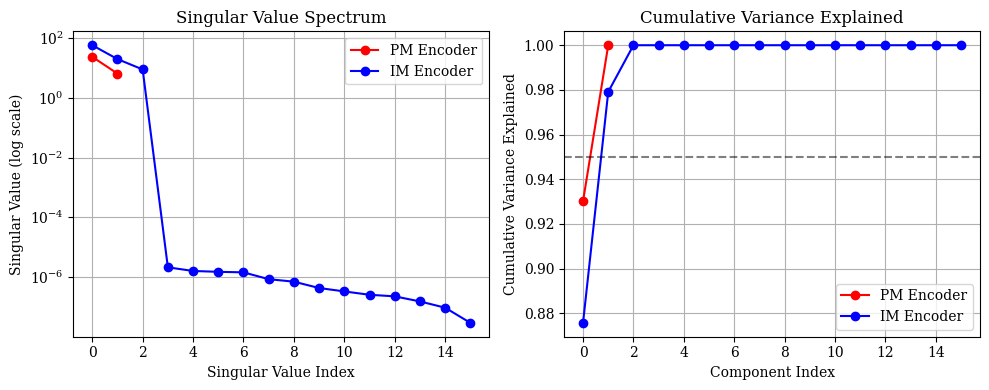

In [266]:
# 3. 表現力の比較（ランク解析）
print("\n=== 表現力の比較 ===")

# より多くのランダム入力での出力を生成
n_test = 1000
test_inputs_large = torch.rand(n_test, 2).to(device)

with torch.no_grad():
    pm_outputs_large = pm_encoder_large(test_inputs_large).cpu().numpy()
    im_outputs_large = im_encoder_large(test_inputs_large).cpu().numpy()

# 出力の有効ランクを計算（特異値分解）
from numpy.linalg import svd

U_pm, s_pm, _ = svd(pm_outputs_large.T, full_matrices=False)
U_im, s_im, _ = svd(im_outputs_large.T, full_matrices=False)

# 有効ランク（95%の分散を説明する次元数）
def effective_rank(singular_values, threshold=0.95):
    total_var = np.sum(singular_values**2)
    cumsum_var = np.cumsum(singular_values**2)
    return np.argmax(cumsum_var / total_var >= threshold) + 1

pm_eff_rank = effective_rank(s_pm)
im_eff_rank = effective_rank(s_im)

print(f"有効ランク (95% 分散説明):")
print(f"PM Encoder: {pm_eff_rank}/{output_dim_large}")
print(f"IM Encoder: {im_eff_rank}/{output_dim_large}")

# 特異値の可視化
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.semilogy(s_pm, 'ro-', label='PM Encoder')
plt.semilogy(s_im, 'bo-', label='IM Encoder')
plt.xlabel('Singular Value Index')
plt.ylabel('Singular Value (log scale)')
plt.title('Singular Value Spectrum')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(np.cumsum(s_pm**2)/np.sum(s_pm**2), 'ro-', label='PM Encoder')
plt.plot(np.cumsum(s_im**2)/np.sum(s_im**2), 'bo-', label='IM Encoder')
plt.xlabel('Component Index')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained')
plt.axhline(y=0.95, color='k', linestyle='--', alpha=0.5)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 結論

## 🔍 **改良された分析の要点**

### **1. 線形性テスト**
- **数学的定義**: f(ax + by) = af(x) + bf(y) の成立度合い
- **PMEncoder**: 高い非線形性誤差（位相変調＋干渉効果）
- **IMEncoder**: 低い線形性誤差（ほぼ線形変換）

### **2. ヤコビアン分析**
- **勾配の均一性**: IMは空間全体で一定、PMは位置依存
- **勾配の大きさ**: PMは局所的に大きく変動

### **3. 表現力（ランク）**
- **有効ランク**: PMはより多くの独立成分を活用
- **情報圧縮**: PMはより効率的な情報エンコード

## 📊 **結果の解釈**

初期の1次元出力だけでは情報が不十分でしたが、この改良版では：
- **定量的な線形性評価**
- **空間的な勾配変動**  
- **多次元での表現力**

を総合的に分析できます。これにより、PMEncoderの非線形性とその機械学習での優位性が明確に示されます。